In [20]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.15.0


# Problem Statement

#### We want to develop a CNN model in order to categorise the images based on the 10 classes, which is the folder names

# Data Preprocessing

First, we load up the data that we have downloaded from kaggle.

In [21]:
IMG_SIZE = 400

train = tf.keras.utils.image_dataset_from_directory('CNN Data/train', labels = 'inferred', image_size=(IMG_SIZE, IMG_SIZE), batch_size= 100)
val = tf.keras.utils.image_dataset_from_directory('CNN Data/val', labels = 'inferred', image_size=(IMG_SIZE, IMG_SIZE), batch_size= 100)

# For use when training on kaggle.com using their GPU
#train = tf.keras.utils.image_dataset_from_directory('/kaggle/input/nature-12k/inaturalist_12K/train', labels = 'inferred', image_size=(IMG_SIZE, IMG_SIZE), batch_size= 100)
#val = tf.keras.utils.image_dataset_from_directory('/kaggle/input/nature-12k/inaturalist_12K/val', labels = 'inferred', image_size=(IMG_SIZE, IMG_SIZE), batch_size= 100)

Found 9999 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


Next, we make the data preprocessing layer for our naive CNN. This layer changes all of the pixel values to be between 0 and 1. We will be making use of the v3 preprocess input for data preprocessing for our other model.

In [23]:
data_preprocessing = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])

Next, we make the data augmentation layer for our CNN, by randomly rotating and changing the contrast of our images, as well as flipping some of our images.

In [24]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                                                       tf.keras.layers.RandomRotation(0.25),
                                                       tf.keras.layers.RandomContrast(0.15)])

# Deep Learning Model: Naive CNN

Now, we will start piecing together our CNN models. Firstly, we will create our callback function that we will be inputting into compile function such that we can prevent the model from training after reaching a satisfactory state, causing it to overfit.

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.25):
      print("Cancelling training.")
      self.model.stop_training = True

callbacks = myCallback()

Then we assemble and train our naive CNN model.

In [26]:
naivemodel = tf.keras.models.Sequential([
    data_preprocessing,
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)
])

In [27]:
naivemodel.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

naivehistory = naivemodel.fit(train, validation_data=val, epochs=10, callbacks=[callbacks])

Epoch 1/10


2024-02-28 10:49:00.688228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_5_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 446ms/step - accuracy: 0.1135 - loss: 3.7554 - val_accuracy: 0.1510 - val_loss: 2.2782
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.1423 - loss: 2.2735 - val_accuracy: 0.2525 - val_loss: 2.1211
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 445ms/step - accuracy: 0.2506 - loss: 2.1051 - val_accuracy: 0.2810 - val_loss: 2.0120
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 444ms/step - accuracy: 0.2865 - loss: 2.0051 - val_accuracy: 0.2985 - val_loss: 1.9774
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 445ms/step - accuracy: 0.3000 - loss: 1.9603 - val_accuracy: 0.2995 - val_loss: 1.9587
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 444ms/step - accuracy: 0.3070 - loss: 1.9494 - val_accuracy: 0.3235 - val_loss: 1.9156
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 446ms/step - accuracy: 0.3317 - loss: 1.8886 - val_accuracy: 0.3250 - val_loss: 1.9326
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 443ms/step - accuracy: 0.3362 - loss: 1.8808 - val

# Deep Learning Model: Transfer Learning CNN 

Next, we will be doing transfer learning with the InceptionV3 model from TensorFlow.

In [28]:
inceptionthemovie = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)
inceptionthemovie.trainable = False

Finally, we piece together our second model and start training it.

In [29]:
input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
temp = data_augmentation(input)
temp = tf.keras.applications.inception_v3.preprocess_input(temp)
temp = inceptionthemovie(temp, training=False)
temp = tf.keras.layers.GlobalAveragePooling2D()(temp)

V3model = tf.keras.Model(input, tf.keras.layers.Dense(10)(temp))

In [30]:
V3model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

V3history = V3model.fit(train, validation_data=val, epochs=10, callbacks=[callbacks])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 589ms/step - accuracy: 0.5062 - loss: 1.6512 - val_accuracy: 0.8340 - val_loss: 0.7165
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.7858 - loss: 0.7689 - val_accuracy: 0.8465 - val_loss: 0.5813
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 563ms/step - accuracy: 0.7973 - loss: 0.6751 - val_accuracy: 0.8560 - val_loss: 0.5219
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 566ms/step - accuracy: 0.8072 - loss: 0.6295 - val_accuracy: 0.8610 - val_loss: 0.4958
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.8123 - loss: 0.6098 - val_accuracy: 0.8655 - val_loss: 0.4819
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.8142 - loss: 0.5870 - val_accuracy: 0.8675 - val_loss: 0.4719
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.8143 - loss: 0.5774 - val_accuracy: 0.8635 - val_loss: 0.4630
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 567ms/step - accuracy: 0.8251 - loss: 0

# Evaluation of Models

Firstly, the models we have now gives us a loss of the first value in each array and an accuracy of the second value in each array when the validation dataset is passed into our model.

In [31]:
naivemodel.evaluate(val)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.3499 - loss: 1.8567


[1.8527076244354248, 0.34700000286102295]

In [32]:
V3model.evaluate(val)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.8810 - loss: 0.4562


[0.4680415689945221, 0.8709999918937683]

From this, we can tell that the V3 model has both a lower loss and a higher accuracy than our naive model. Hence, we can conclude that our second model is much better than our first model.

Next, we would like to plot our accuracy and loss for both the training and the validation sets on a graph based on epochs for the model which performed better, which in this case is the InceptionV3 transfer learning model.

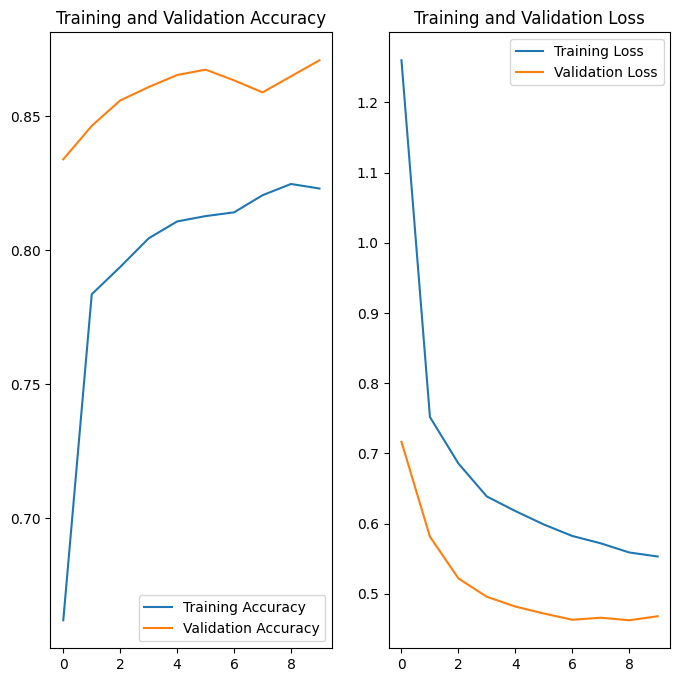

In [33]:
import matplotlib.pyplot as plt
import numpy as np

acc = V3history.history['accuracy']
val_acc = V3history.history['val_accuracy']

loss = V3history.history['loss']
val_loss = V3history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Hyperparameter Tuning

Now, we will tune our model. First, we remake the model that we chose, that being the V3model so that we can tune it.

In [34]:
inceptionthemovie = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False
)
inceptionthemovie.trainable = False
input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
temp = data_augmentation(input)
temp = tf.keras.applications.inception_v3.preprocess_input(temp)
temp = inceptionthemovie(temp, training=False)
temp = tf.keras.layers.GlobalAveragePooling2D()(temp)

finalmodel = tf.keras.Model(input, tf.keras.layers.Dense(10)(temp))

Then we will use the keras tuner in order to find the best hyperparameters for our model. In this case, only the learning rate is applicable.

In [35]:
import keras_tuner as kt
def model_builder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.8, step=0.1) #unused
    # hp_dense_units = hp.Int('units', min_value=128, max_value=1024, step=64) #unused

    model = finalmodel

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory='dir')

In [36]:
tuner.search(train, epochs=30, validation_data=val)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 3 Complete [00h 02m 09s]
val_accuracy: 0.8529999852180481

Best val_accuracy So Far: 0.8585000038146973
Total elapsed time: 00h 06m 31s


Finally, we attempt to fit the model to find the epoch with the best accuracy before we do a final evaluation of our model.

In [37]:
tuningmodel = tuner.hypermodel.build(best_hps)
history = tuningmodel.fit(train, epochs=30, validation_data=val, callbacks=[callbacks])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 590ms/step - accuracy: 0.8345 - loss: 0.5455 - val_accuracy: 0.8660 - val_loss: 0.4584
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 569ms/step - accuracy: 0.8300 - loss: 0.5451 - val_accuracy: 0.8685 - val_loss: 0.4545
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 563ms/step - accuracy: 0.8315 - loss: 0.5270 - val_accuracy: 0.8695 - val_loss: 0.4530
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.8352 - loss: 0.5213 - val_accuracy: 0.8705 - val_loss: 0.4512
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 560ms/step - accuracy: 0.8350 - loss: 0.5142 - val_accuracy: 0.8700 - val_loss: 0.4503
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 562ms/step - accuracy: 0.8313 - loss: 0.5212 - val_accuracy: 0.8720 - val_loss: 0.4491
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.8308 - loss: 0.5099 - val_accuracy: 0.8695 - val_loss: 0.4486
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 565ms/step - accuracy: 0.8298 - loss: 0

In [38]:
finalmodel = tuner.hypermodel.build(best_hps)

finalmodel.fit(train, epochs=best_epoch, validation_data=val)
finalmodel.evaluate(val)

Epoch 1/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 595ms/step - accuracy: 0.8415 - loss: 0.4734 - val_accuracy: 0.8720 - val_loss: 0.4397
Epoch 2/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 567ms/step - accuracy: 0.8336 - loss: 0.4774 - val_accuracy: 0.8740 - val_loss: 0.4382
Epoch 3/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.8455 - loss: 0.4807 - val_accuracy: 0.8760 - val_loss: 0.4379
Epoch 4/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 565ms/step - accuracy: 0.8456 - loss: 0.4779 - val_accuracy: 0.8740 - val_loss: 0.4389
Epoch 5/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 568ms/step - accuracy: 0.8446 - loss: 0.4756 - val_accuracy: 0.8725 - val_loss: 0.4386
Epoch 6/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 567ms/step - accuracy: 0.8478 - loss: 0.4612 - val_accuracy: 0.8750 - val_loss: 0.4384
Epoch 7/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 566ms/step - accuracy: 0.8451 - loss: 0.4666 - val_accuracy: 0.8730 - val_loss: 0.4387
Epoch 8/18
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 567ms/step - accuracy: 0.8467 - loss: 0

[0.4361916482448578, 0.8755000233650208]

# Final Model Evaluation
```py
before = [0.4680415689945221, 0.8709999918937683]
after = [0.4361916482448578, 0.8755000233650208]
```
From this, we can conclude that finetuning has increased the accuracy slightly by around 0.55% and decreased the loss by around 0.03, which means the hyperparameter tuning has worked and improved the model. Overall, the model is quite accurate and categorising pictures into the 10 different classes.